# Predição de séries temporais utilizando redes neurais recorrentes simples,  LSTM e GRU e CNN1D


Aqui desenvolveremos duas redes neurais recorrentes, dos tipos simples, LSTM e GRU, utilizando o Keras, para demonstrar sua capacidade em prever séries temporais


In [76]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

Para garantir que nossos resultados sejam reprodutíveis, vamos fixar a semente de aleatorização (random seed) 

In [77]:
# fixa random seed para garantir reprodutibilidade
np.random.seed(0)

## Carregando os dados

O dataset a ser utilizado é a produção de $CO_2$ em partes por milhão (ppm) do vulcão Mauna Loa
(https://en.wikipedia.org/wiki/Mauna_Loa) entre 1965-1980 por mês. 

Os dados serão carregados utilizando o Pandas. 

In [78]:
# carrega o dataset
df = pd.read_csv('./co2-ppm-mauna-loa-19651980.csv', engine='python', skipfooter=3)
data = df['CO2 (ppm) mauna loa, 1965-1980']
print('Quantidade de dados no arquivo:',len(data))

Quantidade de dados no arquivo: 192


## Visualizando os dados

In [79]:
df

,Month,"CO2 (ppm) mauna loa, 1965-1980"
0,1965-01,319.32
1,1965-02,320.36
2,1965-03,320.82
3,1965-04,322.06
4,1965-05,322.17
...,...,...
187,1980-08,337.19
188,1980-09,335.49
189,1980-10,336.63
190,1980-11,337.74


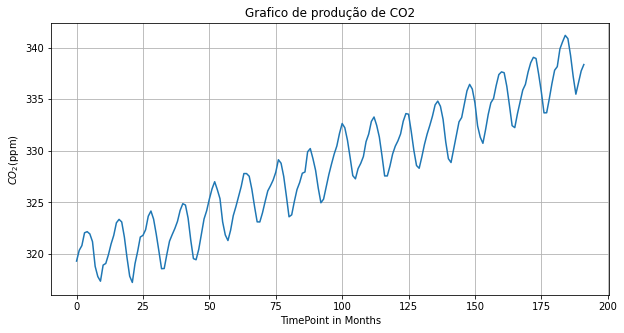

In [80]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.title("Grafico de produção de CO2")
plt.plot(data);

## Indexação

O indice do Dataframe precisa ser do tipo Temoral com frequência mensal

In [81]:
df['Month'] = pd.to_datetime(df['Month'])
# Set the column 'Date' as index (skip if already done)
df = df.set_index('Month')
# Specify datetime frequency
df = df.asfreq('M')
df['CO2 (ppm) mauna loa, 1965-1980'] = list(data[:-1])

In [82]:
df.index

DatetimeIndex(['1965-01-31', '1965-02-28', '1965-03-31', '1965-04-30',
               '1965-05-31', '1965-06-30', '1965-07-31', '1965-08-31',
               '1965-09-30', '1965-10-31',
               ...
               '1980-02-29', '1980-03-31', '1980-04-30', '1980-05-31',
               '1980-06-30', '1980-07-31', '1980-08-31', '1980-09-30',
               '1980-10-31', '1980-11-30'],
              dtype='datetime64[ns]', name='Month', length=191, freq='M')

In [83]:
df

,"CO2 (ppm) mauna loa, 1965-1980"
Month,
1965-01-31,319.32
1965-02-28,320.36
1965-03-31,320.82
1965-04-30,322.06
1965-05-31,322.17
...,...
1980-07-31,339.25
1980-08-31,337.19
1980-09-30,335.49


## Decomposição da serie temporal



*   Observado : Serie temporal sem ruidos
*   Tendência : Função ( Similar a uma reta ) que indica alta, queda ou constância
*   Sazonalidade : Mininos e Máximos repetidos ao decorrer do tempo
*   Resíduo (Erro do modelo)



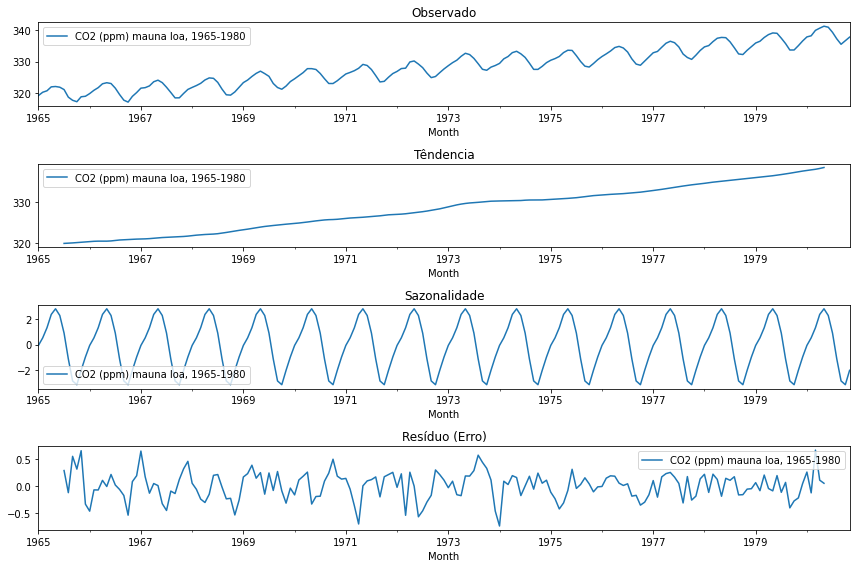

In [84]:
result = seasonal_decompose(df)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1, title = "Observado")
result.trend.plot(ax=ax2, title ="Têndencia")
result.seasonal.plot(ax=ax3, title ="Sazonalidade")
result.resid.plot(ax=ax4, title ="Resíduo (Erro)")
plt.tight_layout()

## Predição de emissões futuras

### Pre-processing

Em séries temporais, a sequência dos dados é importante. Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste. 


In [90]:
# split into train and test sets
train_size = int(len(data) * 0.7)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(data)]
print('Dataset de treinamento contém: ', len(train),' dados')
print('Dataset de teste contém: ', len(test),' dados')

Dataset de treinamento contém:  134  dados
Dataset de teste contém:  57  dados


Os LSTMs são sensíveis à escala dos dados de entrada, especificamente quando as funções de ativação sigmóide ou tanh são usadas. É fundamental normalizar os dados para o intervalo de [0, 1]. Isso pode ser feito usando a classe de pré-processamento MinMaxScaler da biblioteca scikit-learn.

#### Scalando os dados

Use o MinMaxScaler para normalizar o conjunto de treinamento e testes entre 0 e 1. 

In [91]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_train = scaler.fit_transform(df)
norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

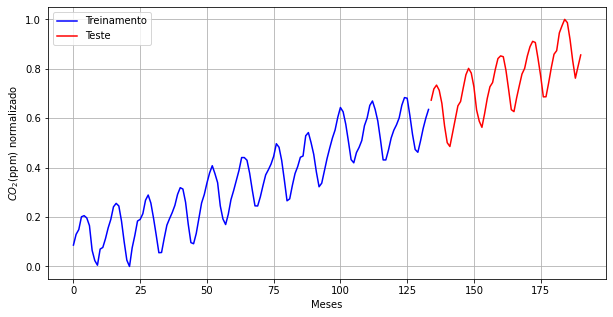

In [92]:
plt.figure(figsize=[10,5])
plt.xlabel('Meses')
plt.ylabel('$CO_2$(ppm) normalizado')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Treinamento','Teste']);

#### Sampling
Redes recorrente necessitam de dados passados para predizer os dados futuros, com isso, precisamos definir o valor do look_back, variavel que contabilisa o numero de momentos prévios a serem analisados.


In [93]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

In [94]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 6 # olha somente para a amostra anterior para prever a próxima amostra


In [107]:
data = np.array(data).reshape((-1,1))

O formato dos dados esperado: [sample, time steps, features].

Atualmente, os dados estão no formato: [samples, features], e estamos modelando o problema como um timestep para cada amostra.

In [108]:
# # reshape a entrada para [samples, time steps, features]
def reshape_train_test(look_back, split_size):
    trainX_whole, trainY_whole = split_X_y(norm_train, look_back)
    testX, testY = split_X_y(norm_test, look_back)
    print(trainX_whole.shape[0])
    print( data.shape[1])
    trainX_whole = np.reshape(trainX_whole, (trainX_whole.shape[0], look_back, data.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], look_back, data.shape[1]))

    # cria o dataset de validação
    trainX, valX, trainY, valY = train_test_split(trainX_whole, trainY_whole, test_size=split_size)
    return trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY

In [109]:
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

print('Shape de x_train', trainX.shape)
print('Shape de x_val', valX.shape)
print('Shape de x_test', testX.shape)

print('Shape de y_train', trainY.shape)
print('Shape de y_val', valY.shape)
print('Shape de y_test', testY.shape)

128
1
Shape de x_train (38, 6, 1)
Shape de x_val (90, 6, 1)
Shape de x_test (51, 6, 1)
Shape de y_train (38, 1)
Shape de y_val (90, 1)
Shape de y_test (51, 1)


## Treinado modelos 

Vamos agora projetar e ajustar diferentes modelos de series temporais.

### Rede RNN simples

In [110]:
# cria e ajusta a RNN simples 
K.clear_session()
model = Sequential()
model.add(SimpleRNN(4, input_shape=(look_back,data.shape[1])))#o 4 é o num
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/20
38/38 [==============================] - 22s 24ms/step - loss: 0.3894 - val_loss: 0.1932
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 0.1794 - val_loss: 0.1089
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1242 - val_loss: 0.0615
Epoch 4/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0660 - val_loss: 0.0361
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0340 - val_loss: 0.0265
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0247
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0253
Epoch 8/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0250
Epoch 9/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0243
Epoch 10/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0235
Epoch 11/20
38/38

#### Previsão e Resultados


In [111]:
def plot_history_predictions(history, Xtrain, Ytrain, Xtest, Ytest, scaler, model, title, xlabel, ylabel, lookback):
    # Resumo do historico de loss
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
    plt.show()

    # faz as predições
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xtest)

    # inverte as predições
    trainPredict = scaler.inverse_transform(trainPredict)
    trainYTrue = scaler.inverse_transform(Ytrain)
    testPredict = scaler.inverse_transform(testPredict)
    testYTrue = scaler.inverse_transform(Ytest)

    # calcula o root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
    print('Treinamento: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
    print('Teste: %.2f RMSE' % (testScore))

    plt.figure(figsize=[10,5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(range(len(data)),data,'k.')
    plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
    plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
    plt.legend(['Original','Treinamento','Teste']);
    

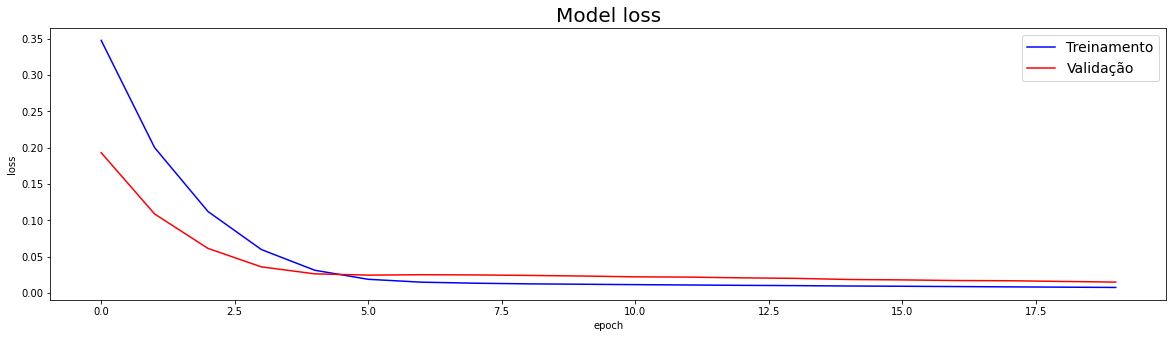

Treinamento: 2.72 RMSE
Teste: 5.43 RMSE


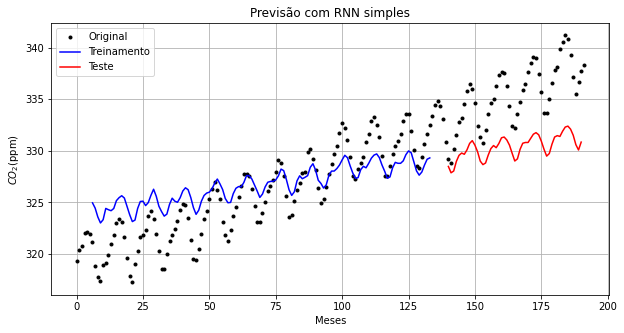

In [112]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, model, 
                         'Previsão com RNN simples', 'Meses', '$CO_2$(ppm)', look_back)

### Rede LSTM 1

Vamos agora projetar e ajustar nossa rede LSTM.


In [113]:
# cria e ajusta a rede LSTM 
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, input_shape=(look_back, data.shape[1])))
modelLSTM.add(Dense(1))

modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/20
38/38 [==============================] - 4s 19ms/step - loss: 0.2236 - val_loss: 0.1162
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1195 - val_loss: 0.0648
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0630 - val_loss: 0.0335
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.0301
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0321
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.0323
Epoch 7/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0311
Epoch 8/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0298
Epoch 9/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0296
Epoch 10/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0289
Epoch 11/20
38/38 

#### Previsão e Resultados

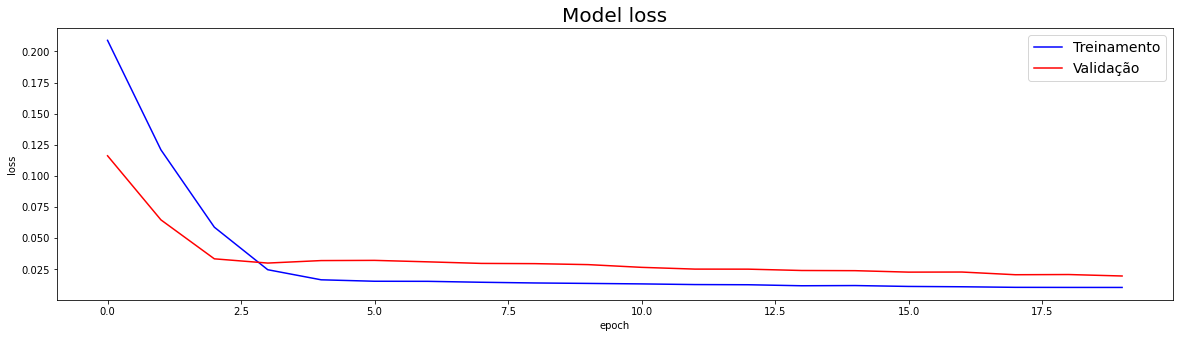

Treinamento: 3.10 RMSE
Teste: 5.19 RMSE


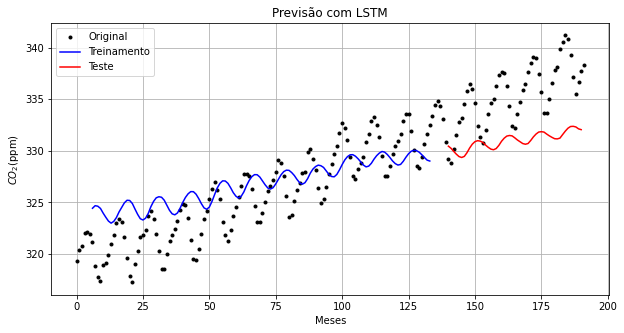

In [114]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Rede LSTM 2


In [ ]:
look_back = 5# olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)


In [116]:
del modelLSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(11, input_shape=(look_back,data.shape[1])))

#modelLSTM.add(Dropout(0.05))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')
history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=40, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/40
38/38 [==============================] - 2s 19ms/step - loss: 0.0939 - val_loss: 0.0514
Epoch 2/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0197
Epoch 3/40
38/38 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 4/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0168
Epoch 5/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 6/40
38/38 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0144
Epoch 7/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0140
Epoch 8/40
38/38 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 9/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 10/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0127
Epoch 11/40
38/38 

#### Previsão e Resultados

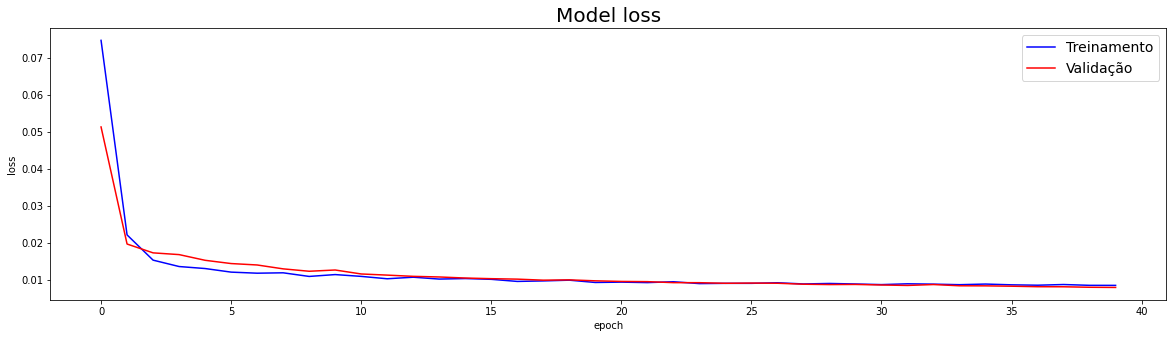

Treinamento: 2.14 RMSE
Teste: 2.66 RMSE


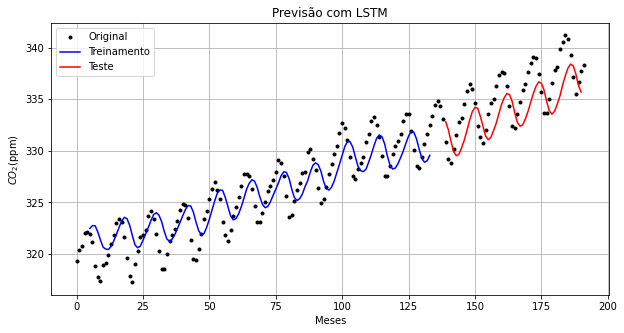

In [117]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Rede GRU

Utilizar outro modelo, a GRU


In [118]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 7 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

127
1


In [119]:
modelGRU = Sequential()
modelGRU.add(GRU(9, input_shape=(look_back, data.shape[1])))
#modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1))
modelGRU.compile(loss='mean_squared_error', optimizer='adam')
history = modelGRU.fit(trainX, 
                    trainY, 
                    epochs= 60, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/60
38/38 [==============================] - 3s 18ms/step - loss: 0.0938 - val_loss: 0.0361
Epoch 2/60
38/38 [==============================] - 0s 6ms/step - loss: 0.0340 - val_loss: 0.0166
Epoch 3/60
38/38 [==============================] - 0s 6ms/step - loss: 0.0219 - val_loss: 0.0148
Epoch 4/60
38/38 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0131
Epoch 5/60
38/38 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0121
Epoch 6/60
38/38 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 7/60
38/38 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0091
Epoch 8/60
38/38 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 9/60
38/38 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 10/60
38/38 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 11/60
38/38 

#### Previsão e Resultados

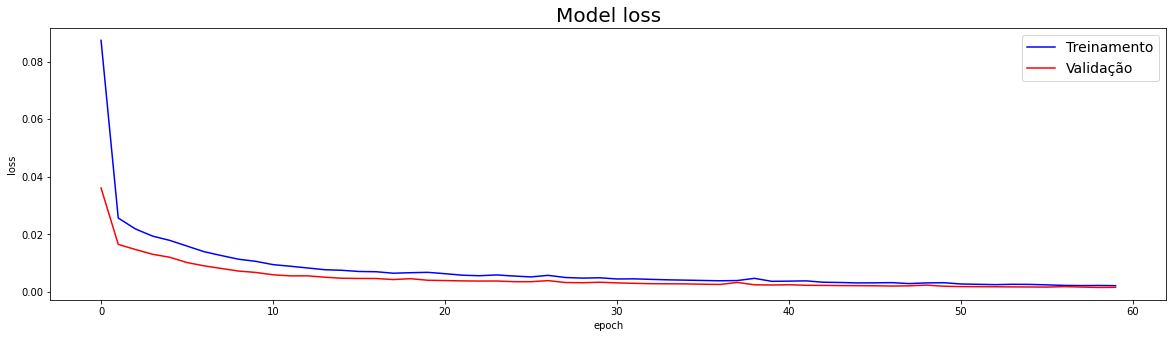

Treinamento: 1.01 RMSE
Teste: 1.19 RMSE


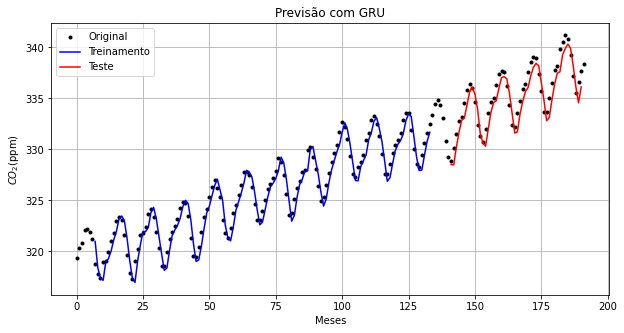

In [120]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelGRU, 
                         'Previsão com GRU', 'Meses', '$CO_2$(ppm)', look_back)


### Rede CNN1D

Utilizar outro modelo, a CNN1D


In [121]:
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
modelCNN1D.add(MaxPooling1D(pool_size=1))
modelCNN1D.add(Dropout(0.05))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(10, activation='tanh'))
modelCNN1D.add(Dense(1, activation='linear'))

modelCNN1D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 64)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                4490      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [125]:
tx = 0.001
verbose = 1
epochs = 60
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1D.compile(loss=[perda], optimizer=keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1D.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/60
2/2 [==============================] - 1s 334ms/step - loss: 0.0496 - mse: 0.0041 - val_loss: 0.0300 - val_mse: 0.0014
Epoch 2/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0331 - mse: 0.0018 - val_loss: 0.0314 - val_mse: 0.0015
Epoch 3/60
2/2 [==============================] - 0s 23ms/step - loss: 0.0370 - mse: 0.0023 - val_loss: 0.0296 - val_mse: 0.0013
Epoch 4/60
2/2 [==============================] - 0s 24ms/step - loss: 0.0377 - mse: 0.0028 - val_loss: 0.0321 - val_mse: 0.0015
Epoch 5/60
2/2 [==============================] - 0s 25ms/step - loss: 0.0305 - mse: 0.0017 - val_loss: 0.0317 - val_mse: 0.0015
Epoch 6/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0360 - mse: 0.0022 - val_loss: 0.0345 - val_mse: 0.0018
Epoch 7/60
2/2 [==============================] - 0s 23ms/step - loss: 0.0392 - mse: 0.0023 - val_loss: 0.0321 - val_mse: 0.0015
Epoch 8/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0399 - mse: 0.0024 - va

#### Previsão e Resultados

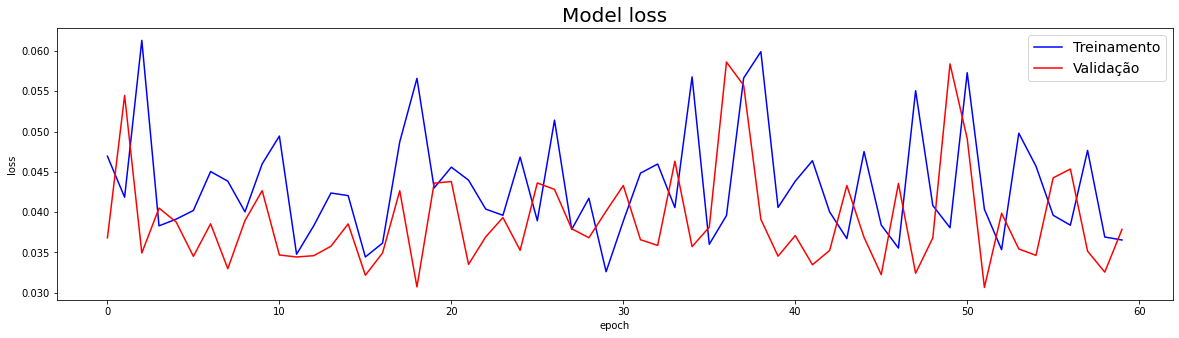

Treinamento: 1.21 RMSE
Teste: 1.68 RMSE


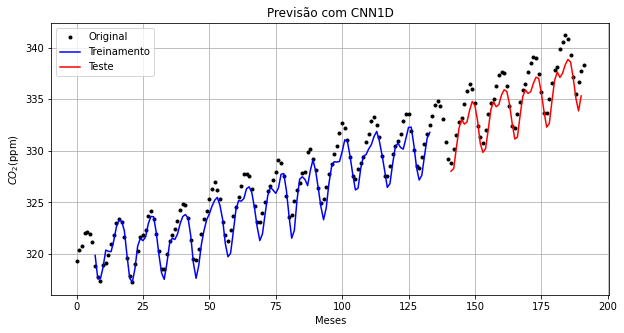

In [124]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1D, 
                         'Previsão com CNN1D', 'Meses', '$CO_2$(ppm)', look_back)


# Melhores resultados 
1. Rede GRU   : 
  *   loss: 0.0017 - val_loss: 0.0016
  *   train_rmse: 1.01 - teste_rmse: 1.19

2. Rede CNN1D   : 
  *   loss: 0.0331 - val_loss: 0.0306
  *   train_rmse: 1.21 - teste_rmse: 1.68

3. Rede LSTM 2:
  *   loss: 0.0091 - val_loss: 0.0080
  *   train_rmse: 2.14 - teste_rmse: 2.66

4. Rede LSTM 1: 
  *   loss: loss: 0.0069 - val_loss: 0.0197
  *   train_rmse: 3.10 - teste_rmse: 5.19
  
5. Rede RNN 1     : 

  *   loss: 0.0083 - val_loss: 0.0151
  *   train_rmse: 2.72 - teste_rmse: 5.43




